In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, sqrt, atan2
import numpy as np

### Load data

In [3]:
data = pd.read_csv("cities.csv")
data.head()

,city,country,venue,lat,lon,date,continent
0,Glendale,USA,State Farm Stadium,33.527723,-112.262506,2023-03-17,North America
1,Glendale,USA,State Farm Stadium,33.527723,-112.262506,2023-03-18,North America
2,Paradise,USA,Allegiant Stadium,36.090945,-115.183258,2023-03-24,North America
3,Paradise,USA,Allegiant Stadium,36.090945,-115.183258,2023-03-25,North America
4,Arlington,USA,AT&T Stadium,32.748178,-97.093275,2023-03-31,North America


In [4]:
# find (unique) cities and drop dates
cities_all = data.drop_duplicates(subset="city", keep="first").drop(columns='date').reset_index(drop=True)
cities_all.head()

,city,country,venue,lat,lon,continent
0,Glendale,USA,State Farm Stadium,33.527723,-112.262506,North America
1,Paradise,USA,Allegiant Stadium,36.090945,-115.183258,North America
2,Arlington,USA,AT&T Stadium,32.748178,-97.093275,North America
3,Tampa,USA,Raymond James Stadium,27.975945,-82.503431,North America
4,Houston,USA,NRG Stadium,29.684955,-95.410740,North America


In [11]:
number_all_cities = len(cities_all)
european_cities = cities_all[cities_all['continent']=='Europe'].reset_index(drop=True)
US_cities = cities_all[cities_all['country']=='USA'].reset_index(drop=True)

print("Number of total concerts:", len(data))
print("Number of cities:", number_all_cities)
print("Number of european cities:", len(european_cities))
print("Number of US cities:", len(US_cities)) 

Number of total concerts: 152
Number of cities: 51
Number of european cities: 18
Number of US cities: 23


In [12]:
# number of possible routes

print("Number of possible routes (Europe):", math.factorial(18))
print("Number of possible routes (US):", math.factorial(23))
print("Number of possible routes (all):", math.factorial(51))

Number of possible routes (Europe): 6402373705728000
Number of possible routes (US): 25852016738884976640000
Number of possible routes (all): 1551118753287382280224243016469303211063259720016986112000000000000


### Calculate distance between cities

In [13]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1-a))

dist = np.zeros((number_all_cities, number_all_cities))
for i in range(number_all_cities):
    for j in range(number_all_cities):
        dist[i,j] = haversine(cities_all.lat[i], cities_all.lon[i], cities_all.lat[j], cities_all.lon[j])

print(dist)

[[   0.          390.26472879 1413.80092349 ... 2419.51823297
  3046.08841275 1966.55055633]
 [ 390.26472879    0.         1697.74380765 ... 2566.31275963
  3141.42118908 1600.90051791]
 [1413.80092349 1697.74380765    0.         ... 1250.68462212
  1957.78012578 2828.34763008]
 ...
 [2419.51823297 2566.31275963 1250.68462212 ...    0.
   708.53911373 3078.33827011]
 [3046.08841275 3141.42118908 1957.78012578 ...  708.53911373
     0.         3358.47050409]
 [1966.55055633 1600.90051791 2828.34763008 ... 3078.33827011
  3358.47050409    0.        ]]


### Plot Graph of all cities

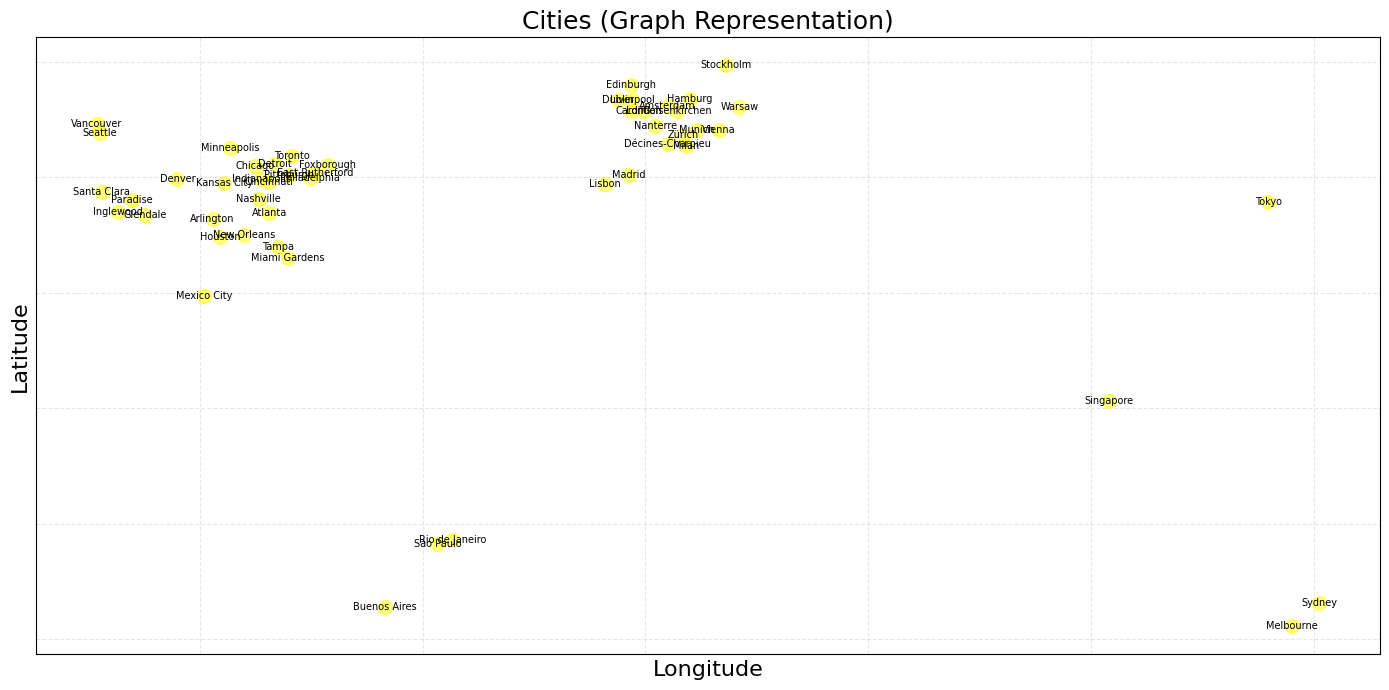

In [ ]:
# create empty graph
Graph_world = nx.Graph()

# add cities to graph
for _, row in cities_all.iterrows():
    Graph_world.add_node(row.city, pos=(row.lon, row.lat))

pos = {city: (lon, lat) for city, (lon, lat) in nx.get_node_attributes(Graph_world, "pos").items()} # dictionary of cities and their coordinates

# plot graph
plt.figure(figsize=(14, 7))
nx.draw_networkx_edges(Graph_world, pos, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(Graph_world, pos, node_size=100, node_color="yellow", alpha=0.5)
nx.draw_networkx_labels(Graph_world, pos, font_size=7, font_color="black")

plt.title("Cities (Graph Representation)", size=18)
plt.xlabel("Longitude", size=16)
plt.ylabel("Latitude", size=16)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

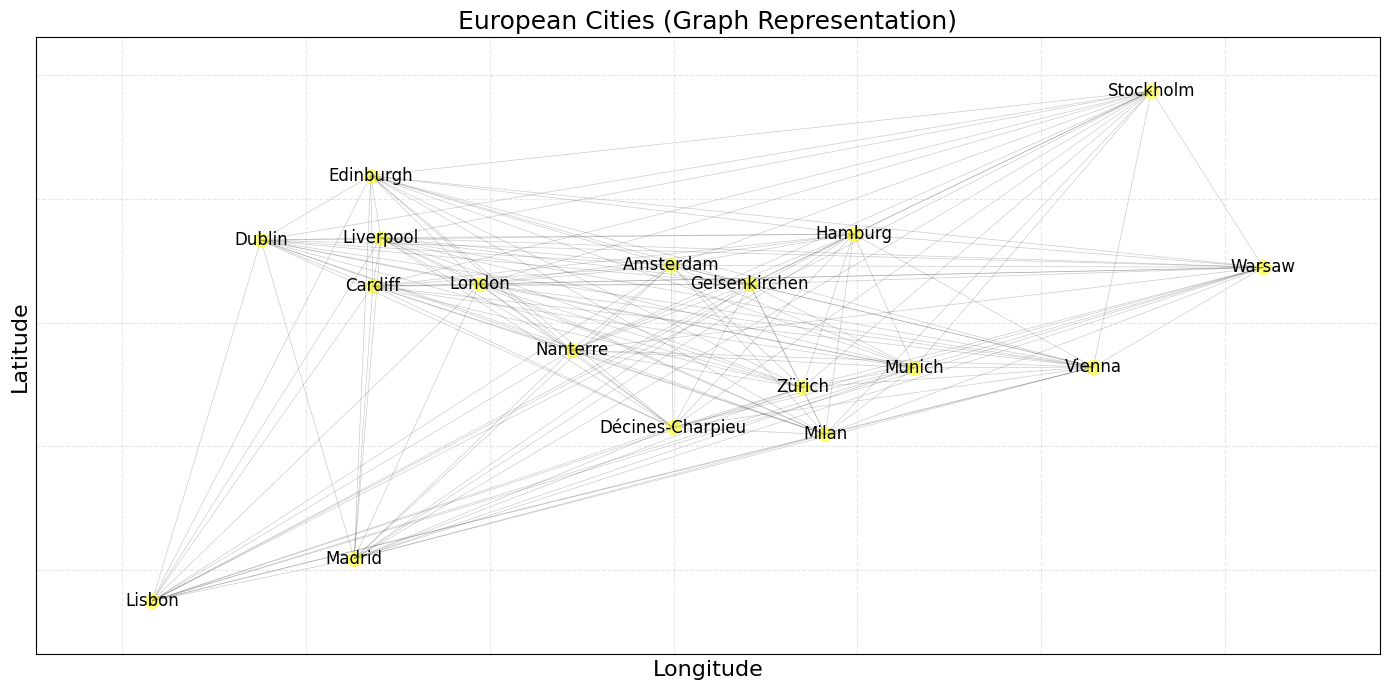

In [21]:
# European Cities

# create empty graph
Graph_europe = nx.Graph()

# add cities to graph
for _, row in european_cities.iterrows():
    Graph_europe.add_node(row.city, pos=(row.lon, row.lat))

# plot boarders between cities
for i in range(len(european_cities)):
    for j in range(i + 1, len(european_cities)):
        dist = haversine(european_cities.lat[i], european_cities.lon[i], european_cities.lat[j], european_cities.lon[j])
        Graph_europe.add_edge(european_cities.city[i], european_cities.city[j], weight=dist)

pos = {city: (lon, lat) for city, (lon, lat) in nx.get_node_attributes(Graph_europe, "pos").items()}

# plot graph
plt.figure(figsize=(14, 7))
nx.draw_networkx_edges(Graph_europe, pos, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(Graph_europe, pos, node_size=100, node_color="yellow", alpha=0.5)
nx.draw_networkx_labels(Graph_europe, pos, font_size=12, font_color="black")

plt.title("European Cities (Graph Representation)", size=18)
plt.xlabel("Longitude", size=16)
plt.ylabel("Latitude", size=16)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# MIP Model

In [16]:
from pyscipopt import Model, quicksum

In [51]:
# define the dataset (cities)
cities = european_cities # US_cities, cities_all, european_cities
number_cities = len(cities)
city_names = list(cities['city'])

# define London as start city
start_city = 8  # London index

# calculate distances between the cities
dist = {(i, j): haversine(cities.loc[i, 'lat'], cities.loc[i, 'lon'], cities.loc[j, 'lat'], cities.loc[j, 'lon']) for i in range(number_cities) for j in range(number_cities) if i != j}

# Create model
model = Model("TSP_Tour")

# Decision variables:  x[i,j] = 1 if there's a path from city i to city j; else 0
x = {}
for (i, j) in dist:
    x[i, j] = model.addVar(vtype="B", name=f"x({i},{j})") # binary

# subtour elimination (MTZ)
u = {} # saves the position of each city in the route
for i in range(number_cities):
    if i != start_city:
        u[i] = model.addVar(vtype="I", lb=1, ub=number_cities - 1, name=f"u({i})")

# objective function: minimize total distances
model.setObjective(quicksum(dist[i, j] * x[i, j] for (i, j) in dist), "minimize")

# constraints
# each city is left exactly once
for i in range(number_cities):
    model.addCons(quicksum(x[i, j] for j in range(number_cities) if i != j) == 1)

# each city is entered exactly once
for j in range(number_cities):
    model.addCons(quicksum(x[i, j] for i in range(number_cities) if i != j) == 1)
    
# subtour elimination (MTZ)
for i in range(number_cities):
    for j in range(number_cities):
        if i != j and i != start_city and j != start_city:
            model.addCons(u[i] - u[j] + number_cities * x[i, j] <= number_cities - 1)

# solve model
model.optimize()

print("Optimal distance:", model.getObjVal())

# save route
edges = [(i, j) for (i, j) in dist if model.getVal(x[i, j]) == 1]
route = [0]
while len(route) < number_cities:
    for (i, j) in edges:
        if i == route[-1]:
            route.append(j)
            break
route.append(route[0])

print("Route:")
print(" → ".join([city_names[i] for i in route]))

presolving:
Optimal distance: 8665.152043819402
Route:
Nanterre → Lisbon → Madrid → Décines-Charpieu → Milan → Zürich → Munich → Vienna → Warsaw → Stockholm → Hamburg → Gelsenkirchen → Amsterdam → Edinburgh → Dublin → Liverpool → Cardiff → London → Nanterre
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 272 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 36 clqs
(round 2, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 272 chg sides, 272 chg coeffs, 36 upgd conss, 0 impls, 36 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 272 changed sides, 272 changed coefficients
 544 implications, 36 cliques
presolved problem has 323 variables

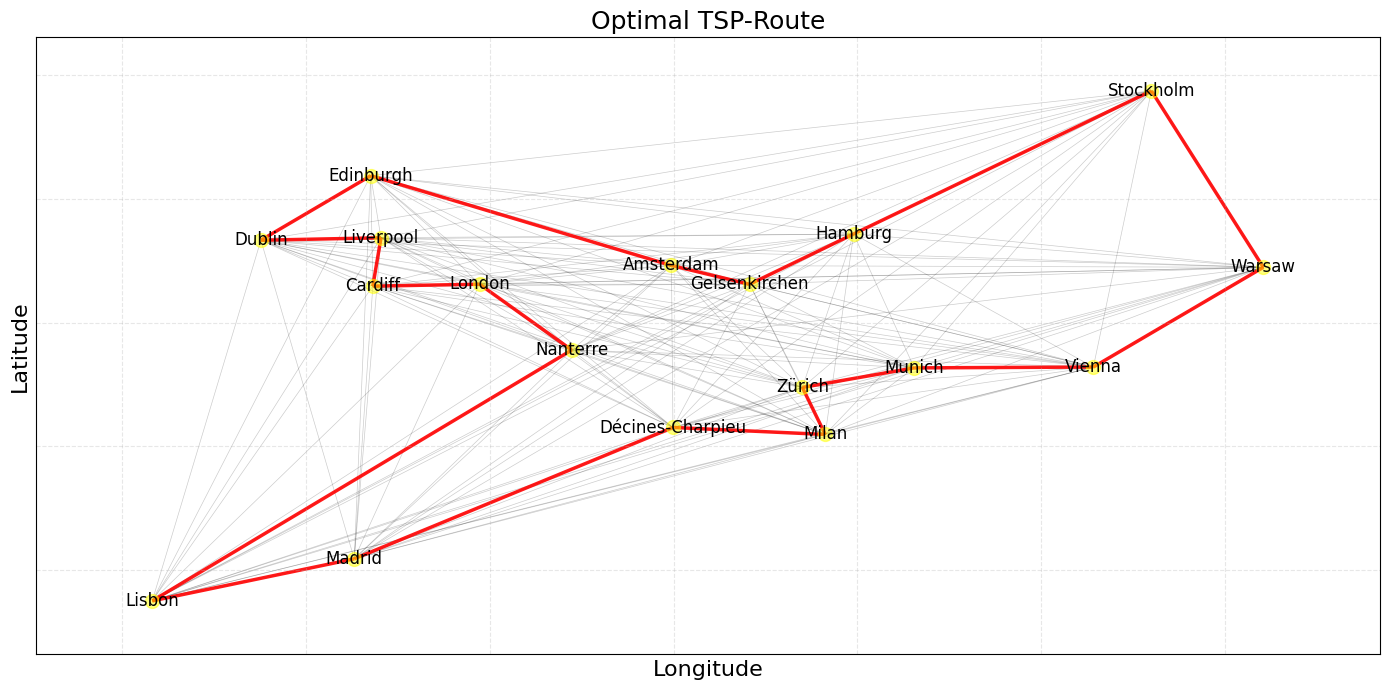

In [52]:
# plot
Graph = nx.Graph()

for _, row in cities.iterrows():
    Graph.add_node(row.city, pos=(row.lon, row.lat))

for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        dist = haversine(cities.lat[i], cities.lon[i], cities.lat[j], cities.lon[j])
        Graph.add_edge(cities.city[i], cities.city[j], weight=dist)

pos = nx.get_node_attributes(Graph, 'pos')

plt.figure(figsize=(14, 7))
nx.draw_networkx_edges(Graph, pos, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(Graph, pos, node_size=100, node_color="yellow", alpha=0.5)
nx.draw_networkx_labels(Graph, pos, font_size=12, font_color="black")

route_cities = [cities.city[i] for i in route]
route_edges = [(route_cities[i], route_cities[i+1]) for i in range(len(route_cities)-1)]

nx.draw_networkx_edges(Graph, pos, edgelist=route_edges, edge_color="red", width=2.5, alpha=0.9)

plt.title("Optimal TSP-Route", size=18)
plt.xlabel("Longitude", size=16)
plt.ylabel("Latitude", size=16)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

osmnx for coordinates. 10, 20,50,100,200,...

In [8]:
cities_all

,city,country,venue,lat,lon,continent
0,Glendale,USA,State Farm Stadium,33.527723,-112.262506,North America
1,Paradise,USA,Allegiant Stadium,36.090945,-115.183258,North America
2,Arlington,USA,AT&T Stadium,32.748178,-97.093275,North America
3,Tampa,USA,Raymond James Stadium,27.975945,-82.503431,North America
4,Houston,USA,NRG Stadium,29.684955,-95.410740,North America
5,Atlanta,USA,Mercedes-Benz Stadium,33.755430,-84.400676,North America
6,Nashville,USA,Nissan Stadium,36.166686,-86.771246,North America
7,Philadelphia,USA,Lincoln Financial Field,39.901625,-75.167567,North America
8,Foxborough,USA,Gillette Stadium,42.091070,-71.264282,North America
9,East Rutherford,USA,MetLife Stadium,40.813693,-74.074511,North America


In [10]:
print(cities_all[['city', 'country']])

                city      country
0           Glendale          USA
1           Paradise          USA
2          Arlington          USA
3              Tampa          USA
4            Houston          USA
5            Atlanta          USA
6          Nashville          USA
7       Philadelphia          USA
8         Foxborough          USA
9    East Rutherford          USA
10           Chicago          USA
11           Detroit          USA
12        Pittsburgh          USA
13       Minneapolis          USA
14        Cincinnati          USA
15       Kansas City          USA
16            Denver          USA
17           Seattle          USA
18       Santa Clara          USA
19         Inglewood          USA
20       Mexico City       Mexico
21      Buenos Aires    Argentina
22    Rio de Janeiro       Brazil
23         São Paulo       Brazil
24             Tokyo        Japan
25         Melbourne    Australia
26            Sydney    Australia
27         Singapore    Singapore
28          Na